# L3-E - Linear Quantization II: Quantizing Weights & Activations for Inference

In this lesson, you will continue to learn different ways of performing linear quantization.

Run the next cell to import all of the functions you have used before in the previous lesson(s) of `Linear Quantization II` to follow along with the video.

- To access the `helper.py` file, you can click `File --> Open...`, on the top left.

In [1]:
import torch

from helper import linear_q_symmetric, get_q_scale_symmetric

## Linear Quantization: Inference

- `W8A32` means weights in 8-bits and activations in 32-bits.
- For simplicity, the linear layer will be without bias.

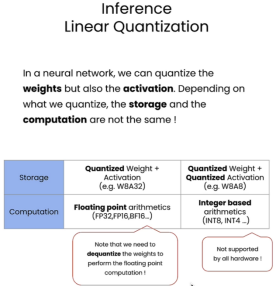

在神经网络中，我们可以对权重进行量化，但是也可以对激活进行量化。  
对不同内容进行量化时，存储和计算也是不同的。  
如果只量化权重，计算将使用浮点运算，包括FP32，FP16，BF16。  
如果不仅量化权重，还量化激活，计算将使用整型运算，包括INT8，INT4。  
对于只量化权重的情况，注意需要对权重进行反量化才能进行浮点运算。  
如果不仅量化权重，还量化激活，将使用基于整数的计算，但并非所有硬件都支持这一点。  
现在让我们看一下当要把权重量化为8-bit且激活保持32-bit时会发生什么，这也称为W8A32模式。  

In [2]:
# quantized_linear_W8A32_without_bias函数可以看作是一个线性层，接收输入input，使用量化后的权重q_w对input进行线性变换（需要先对q_w做反量化），输出output。
# input是线性层的输入，q_w是量化后的权重tensor，s_w是权重tensor的scale，z_w是权重tensor的zero point。
def quantized_linear_W8A32_without_bias(input, q_w, s_w, z_w):
    assert input.dtype == torch.float32  # 确保input的数据类型是float32
    assert q_w.dtype == torch.int8  # 确保q_w的数据类型是INT8

    # 使用量化权重进行线性变换之前，需要将量化权重反量化，然后才能和float32类型的input进行计算，这样得到的激活才能是float32的。
    dequantized_weight = q_w.to(torch.float32) * s_w + z_w

    # 使用反量化后的权重对input进行线性变换，output即激活，它是float32的。
    output = torch.nn.functional.linear(input, dequantized_weight)
    
    return output

In [3]:
# 初始化一个input
input = torch.tensor([1, 2, 3], dtype=torch.float32)
input

tensor([1., 2., 3.])

In [4]:
# 初始化原始权重
weight = torch.tensor([[-2,   -1.13, 0.42],
                       [-1.51, 0.25, 1.62],
                       [0.23,  1.35, 2.15]])

In [5]:
# 对原始权重进行线性对称量化
q_w, s_w  = linear_q_symmetric(weight)

In [6]:
# 量化权重 
q_w

tensor([[-118,  -67,   25],
        [ -89,   15,   96],
        [  14,   80,  127]], dtype=torch.int8)

In [7]:
# 量化scale
s_w

0.016929134609192376

In [8]:
# 使用量化权重q_w对input进行线性变换
output = quantized_linear_W8A32_without_bias(input,
                                             q_w,
                                             s_w,
                                             0)

In [9]:
print(f"This is the W8A32 output: {output}")

This is the W8A32 output: tensor([-2.9965,  3.8768,  9.3957])


In [10]:
# 使用原始权重对input进行线性变换
fp32_output = torch.nn.functional.linear(input, weight)

In [11]:
# 可以看到，使用原始权重或量化权重，线性变换结果是类似的
print(f"This is the output if we don't quantize: {fp32_output}")

This is the output if we don't quantize: tensor([-3.0000,  3.8500,  9.3800])
